## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/geno/geno_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_pubchem_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train = df_train_all['genotoxicity']

X_test = df_test.loc[:, df_test.columns != 'genotoxicity']
y_test = df_test['genotoxicity']

In [5]:
X_train.shape, y_train.shape

((19931, 881), (19931,))

In [6]:
X_test.shape, y_test.shape

((4984, 881), (4984,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP23,...,PubchemFP820,PubchemFP821,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP827,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP860
0,1,0,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,1,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2487,1,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2488,1,0,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2489,1,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_test

,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP23,...,PubchemFP820,PubchemFP821,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP827,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP860
0,1,0,1,1,1,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,1,1,1,0,...,0,1,0,1,0,0,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4979,1,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4980,0,0,0,1,1,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4981,0,0,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4982,0,0,0,1,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
# write

with open('../../pubchem_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['genotoxicity'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [10]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [10]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 50, 'solver': 'lsqr', 'tol': 0.0001} 

Test set:
Tuned model:
MAE: 0.34138834629668346
MSE: 0.21195374078302218
RMSE: 0.46038434028865727
R2 Square 0.08279893194583854 

Base model:
MAE: 0.34148920783212205
MSE: 0.21203216210762205
RMSE: 0.4604695018213715
R2 Square 0.0824595742991393 

Train set:
Tuned model:
MAE: 0.34080415214974125
MSE: 0.2129925634184173
RMSE: 0.4615111736658358
R2 Square 0.12211665510254355 

Base model:
MAE: 0.3417935678226452
MSE: 0.21405200062042198
RMSE: 0.46265754140662396
R2 Square 0.11775001309552846 



In [11]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [18]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [8, 10, 15],
    'n_estimators': [500, 800, 1000],
}


grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 15, 'n_estimators': 1000} 

Test set:
Tuned model:
MAE: 0.3181131486767965
MSE: 0.1875023457859377
RMSE: 0.4330154105640326
R2 Square 0.18860902769545085 

Base model:
MAE: 0.32276177931908806
MSE: 0.19184604352143966
RMSE: 0.4380023327808194
R2 Square 0.1698122648377226 

Train set:
Tuned model:
MAE: 0.22623587319713087
MSE: 0.08570665970720347
RMSE: 0.29275699770834424
R2 Square 0.6467461215726096 

Base model:
MAE: 0.25753115427538703
MSE: 0.11178756734177006
RMSE: 0.3343464779861903
R2 Square 0.5392494368774896 



In [12]:
params = {'max_depth': 15, 'n_estimators': 1000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.3181131486767965
MSE: 0.1875023457859377
RMSE: 0.4330154105640326
R2 Square 0.18860902769545085 

Train set:
MAE: 0.22623587319713087
MSE: 0.08570665970720347
RMSE: 0.29275699770834424
R2 Square 0.6467461215726096 



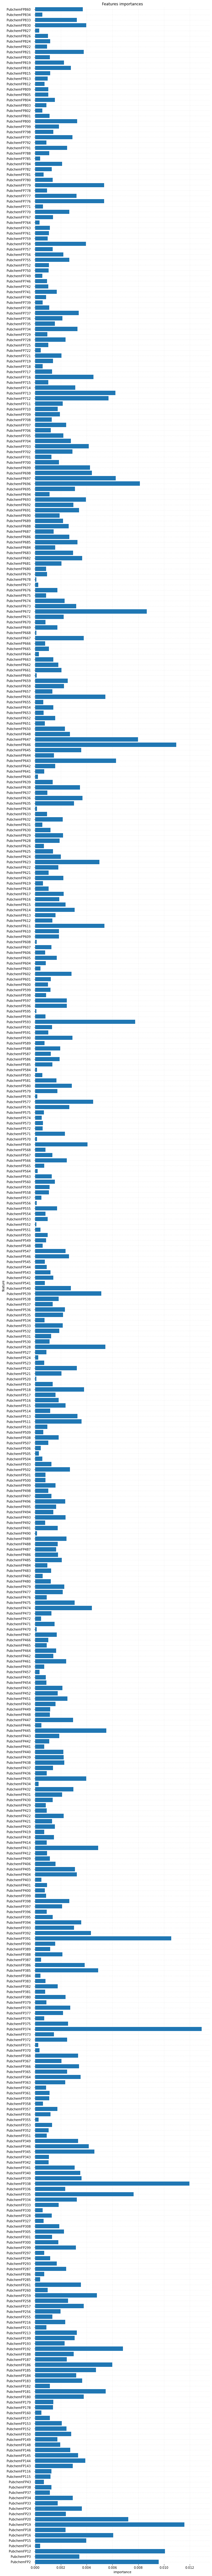

In [20]:
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [13]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [16]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [90, 110, 140],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.30938282211016715
MSE: 0.1799964237557283
RMSE: 0.4242598540467013
R2 Square 0.2210898873273972 

Base model:
MAE: 0.3242065059507994
MSE: 0.19689336462952428
RMSE: 0.443726677842931
R2 Square 0.1479706672606047 

Train set:
Tuned model:
MAE: 0.25194286279389666
MSE: 0.12073074739046734
RMSE: 0.34746330366021005
R2 Square 0.5023886719326245 

Base model:
MAE: 0.27332817665082226
MSE: 0.13644212480954954
RMSE: 0.3693807315082225
R2 Square 0.4376316853963631 



In [11]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.30938282211016715
MSE: 0.1799964237557283
RMSE: 0.4242598540467013
R2 Square 0.2210898873273972 

Train set:
MAE: 0.25194286279389666
MSE: 0.12073074739046734
RMSE: 0.34746330366021005
R2 Square 0.5023886719326245 



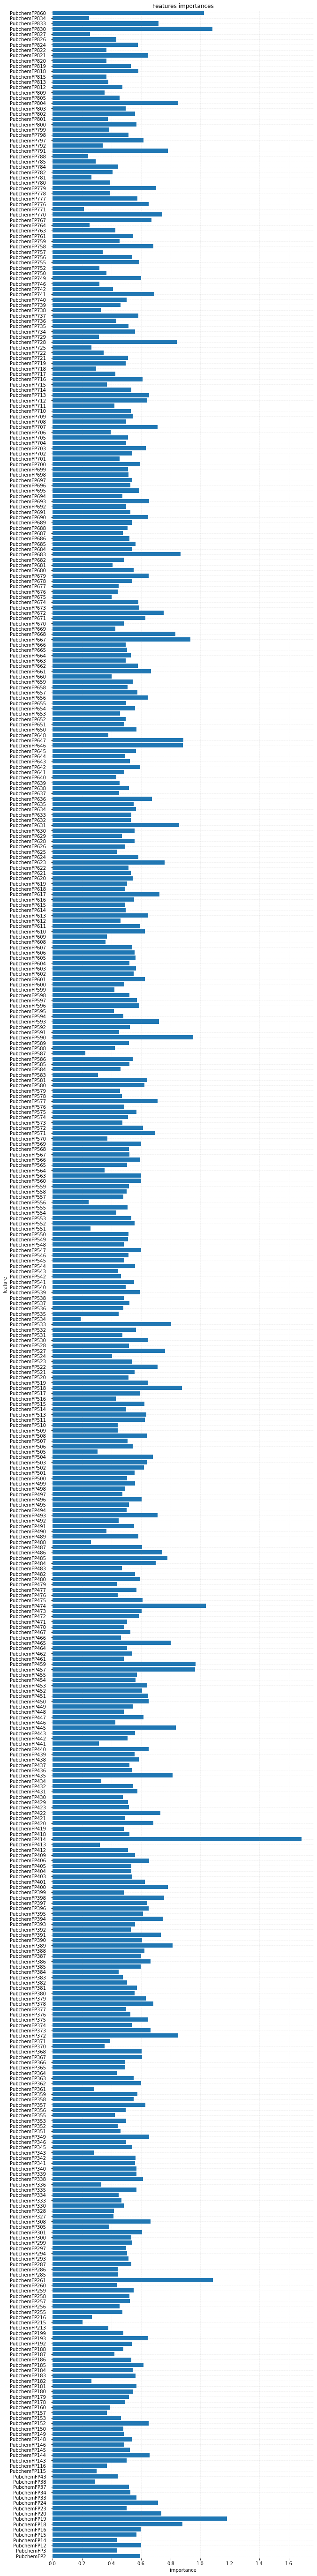

In [18]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609
2,XGBoost,0.309383,0.179996,0.424260,0.221090


## 5.4. LightGBM

Better results - third model.

In [27]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 1500, 2000, 4000],
    'min_child_samples': [30, 55, 65, 90, 100],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.9],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 90, 'n_estimators': 4000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.31266894453710226
MSE: 0.18277187577170967
RMSE: 0.42751827536575515
R2 Square 0.20907949513527646 

Base model:
MAE: 0.3227600760279857
MSE: 0.19118589234897773
RMSE: 0.4372480901604691
R2 Square 0.17266897950679339 

Train set:
Tuned model:
MAE: 0.2670548645309725
MSE: 0.13457004212027404
RMSE: 0.3668378962433871
R2 Square 0.44534777738947773 

Base model:
MAE: 0.3022702413582288
MSE: 0.16635107201496027
RMSE: 0.4078615843824474
R2 Square 0.3143571156478072 



In [16]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 90, 'n_estimators': 4000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.31239480725355845
MSE: 0.18236325617121313
RMSE: 0.4270401107287384
R2 Square 0.2108477410394003 

Train set:
MAE: 0.26679087203542146
MSE: 0.13437148041407476
RMSE: 0.36656715675858736
R2 Square 0.44616618161922694 



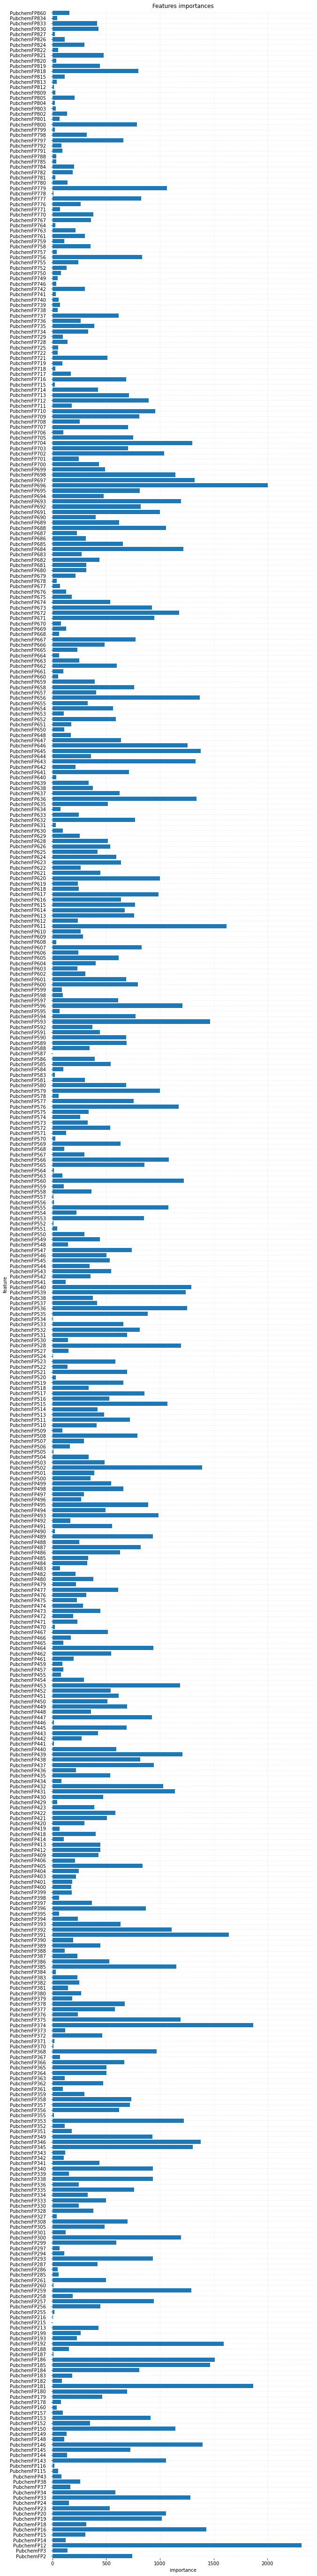

In [29]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [17]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609
2,XGBoost,0.309383,0.179996,0.424260,0.221090
3,LightGBM,0.312395,0.182363,0.427040,0.210848


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [18]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [5, 10, 15, 25],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 20} 

Test set:
Tuned model:
MAE: 0.3231247816859034
MSE: 0.19200228644573428
RMSE: 0.43818065503366793
R2 Square 0.16913614477251637 

Base model:
MAE: 0.3233823832486649
MSE: 0.1914591773984928
RMSE: 0.4375604842744518
R2 Square 0.17148637551795864 

Train set:
Tuned model:
MAE: 0.30228662713745685
MSE: 0.16729106508609715
RMSE: 0.40901230432115016
R2 Square 0.31048278197048995 

Base model:
MAE: 0.3026111859265554
MSE: 0.16735916806535514
RMSE: 0.4090955488212444
R2 Square 0.3102020845120016 



In [18]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 20} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.3231247816859034
MSE: 0.19200228644573428
RMSE: 0.43818065503366793
R2 Square 0.16913614477251637 

Train set:
MAE: 0.30228662713745685
MSE: 0.16729106508609715
RMSE: 0.40901230432115016
R2 Square 0.31048278197048995 



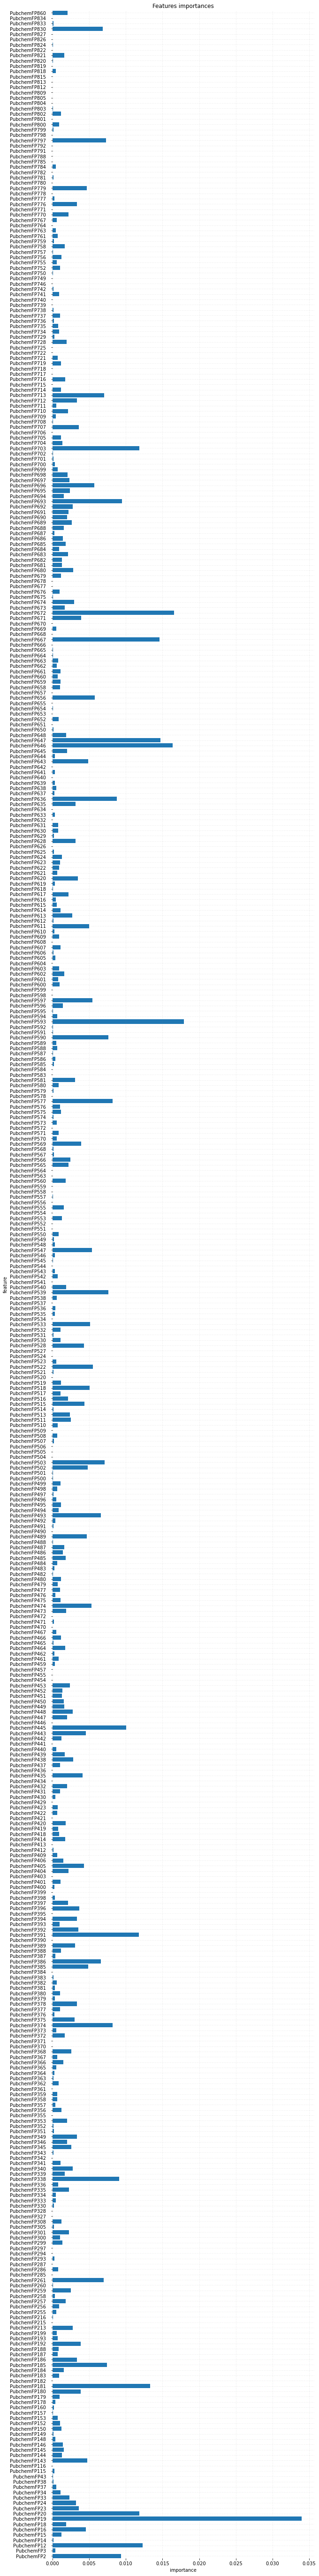

In [20]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [19]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609
2,XGBoost,0.309383,0.179996,0.424260,0.221090
3,LightGBM,0.312395,0.182363,0.427040,0.210848
4,HistGradient Boosting Regressor,0.323125,0.192002,0.438181,0.169136


## 5.6. Support Vector Regression

Better results - fifth model.

In [25]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0, 4.0],
    'epsilon': [0.2, 0.8, 1.8, 2.8],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.3106958673280658
MSE: 0.18629103595177515
RMSE: 0.43161445289954686
R2 Square 0.19385080672484634 

Base model:
MAE: 0.30427585244005684
MSE: 0.1973019091389691
RMSE: 0.44418679532260874
R2 Square 0.14620274630282337 

Train set:
Tuned model:
MAE: 0.23450798854605417
MSE: 0.11486180005247655
RMSE: 0.3389126731954362
R2 Square 0.5265784888793361 

Base model:
MAE: 0.24943720615985948
MSE: 0.159191385997993
RMSE: 0.39898795219654565
R2 Square 0.34386692109882355 



In [20]:
params = {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.3106958673280658
MSE: 0.18629103595177515
RMSE: 0.43161445289954686
R2 Square 0.19385080672484634 

Train set:
MAE: 0.23450798854605417
MSE: 0.11486180005247655
RMSE: 0.3389126731954362
R2 Square 0.5265784888793361 



In [63]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [21]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609
2,XGBoost,0.309383,0.179996,0.424260,0.221090
3,LightGBM,0.312395,0.182363,0.427040,0.210848
4,HistGradient Boosting Regressor,0.323125,0.192002,0.438181,0.169136
5,Support Vector Regression,0.310696,0.186291,0.431614,0.193851


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''


"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [22]:
def average_predictions(X):
    return ((0.15 * rf_best.predict(X)) + \
            (0.30 * xgbr_best.predict(X)) + \
            (0.25 * lgbm_best.predict(X)) + \
            (0.10 * hist_best.predict(X)) + \
            (0.20 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.308881478691801
MSE: 0.17945392012342107
RMSE: 0.42362001855840226
R2 Square 0.22343749822181802 

Train set:
MAE: 0.24948273977527088
MSE: 0.11748199549937308
RMSE: 0.34275646675062615
R2 Square 0.5157789289966379 



In [23]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609
2,XGBoost,0.309383,0.179996,0.424260,0.221090
3,LightGBM,0.312395,0.182363,0.427040,0.210848
4,HistGradient Boosting Regressor,0.323125,0.192002,0.438181,0.169136
5,Support Vector Regression,0.310696,0.186291,0.431614,0.193851
6,Averaging base models,0.308881,0.179454,0.423620,0.223437


### Averaging base models with Meta-model

In [24]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [38]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.121895,5.052355,5.042419,5.018795,5.149838
1,5.085417,5.173562,5.156205,5.089056,5.073220
2,5.280726,5.331196,5.263479,5.285214,5.268307
3,4.869044,4.823525,4.791635,4.884922,4.808058
4,4.765144,4.710500,4.708866,4.818245,4.686137
...,...,...,...,...,...
19926,4.885242,4.870999,4.865373,4.844297,4.749717
19927,4.969687,5.014500,5.049081,4.983925,5.015286
19928,5.154975,5.285643,5.256980,5.130496,5.251589
19929,5.325347,5.347424,5.352258,5.046086,5.578879


In [25]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.3240092061248431
MSE: 0.2113068269023694
RMSE: 0.4596812231344341
R2 Square 0.08559836402984788 

Train set:
MAE: 0.15342317904170208
MSE: 0.04349727546247001
RMSE: 0.20856000446506998
R2 Square 0.8207189346704798 



In [26]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609
2,XGBoost,0.309383,0.179996,0.424260,0.221090
3,LightGBM,0.312395,0.182363,0.427040,0.210848
4,HistGradient Boosting Regressor,0.323125,0.192002,0.438181,0.169136
5,Support Vector Regression,0.310696,0.186291,0.431614,0.193851
6,Averaging base models,0.308881,0.179454,0.423620,0.223437
7,Base models + Meta-model,0.324009,0.211307,0.459681,0.085598


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [10]:
params_rf = {'max_depth': 15, 'n_estimators': 1000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 90, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 90, 'n_estimators': 4000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 20} 

params_svr = {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}

In [11]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])

test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = 6

kf = KFold(n_splits=n_splits,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx] 
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    test1 += model1.predict(X_test)/n_splits   
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))
    del model1

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    test2 += model2.predict(X_test)/n_splits
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    del model2
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    test3 += model3.predict(X_test)/n_splits
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    del model3
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    test4 += model4.predict(X_test)/n_splits
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    del model4
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    test5 += model5.predict(X_test)/n_splits
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    del model5
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.1886525306154445
Model1 R2: 0.19274856457750056
Model2 MSE: 0.1858022366199357
Model2 R2: 0.20494508222687602
Model3 MSE: 0.18836443127818947
Model3 R2: 0.19398135272396588
Model4 MSE: 0.19916102925727422
Model4 R2: 0.14778229465746195
Model5 MSE: 0.19204624676556045
Model5 R2: 0.17822672262467742
Average MSE = 0.19080529490728088
Average R2 = 0.18353680336209638
-------------- fold 2 --------------
Model1 MSE: 0.18948914331012964
Model1 R2: 0.20855383097406033
Model2 MSE: 0.18716912299792934
Model2 R2: 0.218243943853763
Model3 MSE: 0.18994202186209297
Model3 R2: 0.2066622767207449
Model4 MSE: 0.2004349218666361
Model4 R2: 0.16283620117099074
Model5 MSE: 0.19351068600950633
Model5 R2: 0.19175690790292332
Average MSE = 0.1921091792092589
Average R2 = 0.19761063212449645
-------------- fold 3 --------------
Model1 MSE: 0.18344827578442446
Model1 R2: 0.21150614393933054
Model2 MSE: 0.1785408559556085
Model2 R2: 0.23259912160611884
Model3 

In [12]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [13]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.036830,4.919253,4.919641,4.972317,4.797086
1,5.190614,5.236077,5.224070,5.154996,5.252648
2,5.326731,5.271801,5.286578,5.313297,5.214937
3,4.959273,4.926364,4.818671,4.936774,4.842756
4,4.796785,4.765772,4.748903,4.882066,4.848518
...,...,...,...,...,...
19926,5.038634,4.927127,4.892893,4.877805,4.810560
19927,4.996729,5.030356,5.082861,5.031043,5.053676
19928,5.023668,5.204515,5.209828,5.142081,5.155801
19929,5.130228,5.241297,5.241752,4.978856,5.532966


In [14]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,6.529178,6.001892,6.096444,5.810653,5.859715
1,5.048102,5.008121,5.041532,4.993178,4.970361
2,5.019213,4.954672,4.954117,5.043997,4.924598
3,4.796299,4.840613,4.853723,4.849697,4.813457
4,5.132127,4.787792,4.789058,4.950527,4.738010
...,...,...,...,...,...
4979,4.936618,4.857902,4.811338,4.855728,4.810747
4980,4.982448,5.119729,5.139195,5.094780,4.986435
4981,5.203757,5.553134,5.441983,5.221845,5.409468
4982,4.836537,4.913139,4.945769,4.948122,4.861319


In [15]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.30698481012490336
MSE: 0.17924410118324566
RMSE: 0.42337229619242406
R2 Square 0.2243454612297645 

Train set:
MAE: 0.3148711577625575
MSE: 0.1888780162013362
RMSE: 0.4346009850441393
R2 Square 0.22150866687917747 



In [17]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.341388,0.211954,0.460384,0.082799
1,Random Forest Regressor,0.318113,0.187502,0.433015,0.188609
2,XGBoost,0.309383,0.179996,0.424260,0.221090
3,LightGBM,0.312395,0.182363,0.427040,0.210848
4,HistGradient Boosting Regressor,0.323125,0.192002,0.438181,0.169136
5,Support Vector Regression,0.310696,0.186291,0.431614,0.193851
6,Averaging base models,0.308881,0.179454,0.423620,0.223437
7,Base models + Meta-model,0.324009,0.211307,0.459681,0.085598
8,Base models + Meta-model + cv,0.306985,0.179244,0.423372,0.224345
